In [52]:

# Import packages
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

train_x_raw = pd.read_csv("X_train.csv", low_memory = True, index_col=0)
train_y_raw = pd.read_csv("y_train.csv", low_memory = True, index_col=0)
test_x_raw = pd.read_csv("X_test.csv", low_memory=True, index_col=0)

df_train = pd.DataFrame(train_x_raw)
df_test = pd.DataFrame(test_x_raw)
df_y = pd.DataFrame(train_y_raw)

Add all of the preprocessing below

## Variable 1 - 146 Preprocessing

In [53]:
columns_to_drop = ['c_abrv', 'f46_IT', 'v72_DE', 'v73_DE', 'v74_DE', 'v75_DE', 'v76_DE', 'v77_DE', 'v78_DE', 'v79_DE']
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)

## Variable 147 - 292 Preprocessing 

In [54]:
### Function to find the targeted colname
def find_colname(data, target):
    temp = []
    for varname in data.columns:
        if varname.endswith(target):
            temp.append(varname)
    return(temp)

merge_colname = find_colname(train_x_raw, '_11c')
print(find_colname(train_x_raw, 'c'))
print(find_colname(train_x_raw, '_r'))

def merge_columns(dat, colname):
    for name in colname:
        name_org = name.replace("_11c", "")
        dat.loc[dat[name_org] == -4, name_org] = dat.loc[dat[name_org] == -4, name]

['v30c', 'v45c', 'v133_11c', 'v134_11c', 'v135_11c', 'v136_11c', 'v137_11c', 'v138_11c', 'v139_11c', 'v140_11c', 'v141_11c']
['age_r', 'v228b_r', 'v231b_r', 'v233b_r', 'v239_r', 'v242_r', 'v243_r', 'v251b_r', 'v252_r', 'v261_r', 'v262_r', 'v263_r', 'v276_r', 'v278c_r', 'v279c_r', 'v279d_r', 'v281a_r']


## Variable 293 - 438 Preprocessing

In [55]:
## removed string type data
df_train.drop('v228b', inplace=True, axis=1) 
df_test.drop('v228b', inplace=True, axis=1) 

df_train.fillna({'v228b_r': -3}, inplace=True)
df_test.fillna({'v228b_r': -3}, inplace=True)

df_train.drop('v231b', inplace=True, axis=1) 
df_test.drop('v231b', inplace=True, axis=1)

df_train.fillna({'v231b_r': -3}, inplace=True)
df_test.fillna({'v231b_r': -3}, inplace=True)

df_train.drop('v233b', inplace=True, axis=1)
df_test.drop('v233b', inplace=True, axis=1)

df_train.fillna({'v233b_r': -3}, inplace=True)
df_test.fillna({'v233b_r': -3}, inplace=True)

df_train.drop('v251b', inplace=True, axis=1)
df_test.drop('v251b', inplace=True, axis=1) 

df_train.fillna({'v251b_r': -3}, inplace=True)
df_test.fillna({'v251b_r': -3}, inplace=True)

df_train.drop('f252_edulvlb_CH', inplace=True, axis=1)
df_test.drop('f252_edulvlb_CH', inplace=True, axis=1)

## removed the column having 'DE'
df_train.drop(list(df_train.filter(regex='DE')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='DE')), axis=1, inplace=True)

## removed the column having 'GB'
df_train.drop(list(df_train.filter(regex='GB')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='GB')), axis=1, inplace=True)

df_train.drop('v281a', inplace=True, axis=1)
df_test.drop('v281a', inplace=True, axis=1)

# Simple Model Run

In [6]:
# Prepare the DMatrix 
# Convert to 'category' type
# Make sure the conversion is applied to df_train and df_test if they are used for DMatrix
df_train['v275b_N2'] = df_train['v275b_N2'].astype('category')
df_train['v275b_N1'] = df_train['v275b_N1'].astype('category')
df_test['v275b_N2'] = df_test['v275b_N2'].astype('category')
df_test['v275b_N1'] = df_test['v275b_N1'].astype('category')

label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)
# When creating DMatrix, enable categorical support
dtrain = xgb.DMatrix(df_train, label=df_y, enable_categorical=True)
dtest = xgb.DMatrix(df_test, enable_categorical=True)

# Set XGBoost parameters 
params = {
    'max_depth': 6,
    'eta': 0.01,
    'objective': 'multi:softprob',
    'num_class': 5,  # We have 5 classes: 0, 1, 2, 3, 4
    'eval_metric': 'mlogloss',
}
num_boost_round = 400  # Number of boosting rounds

bst = xgb.train(params, dtrain, num_boost_round)
y_test_probs = bst.predict(dtest)

class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class_{class_label}" for class_label in class_order}

submission_df = pd.DataFrame(y_test_probs, columns=class_mapping.values())
submission_df.columns = ['no answer', 'very important', 'quite important', 'not important', 'not at all important']
submission_df.insert(0, 'id', df_test.index)

# Save the submission file
# submission_file = 'submission.csv'
submission_file = 'submission.xlsx'
## submission_df.to_csv(submission_file,lineterminator=None, index=False)
with pd.ExcelWriter(submission_file) as writer:
    submission_df.to_excel(writer, sheet_name="Sheet1") 


# Re-preprocessing

In [126]:
import matplotlib.pyplot as plt

In [56]:
label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)

df_train.drop('v275b_N2', inplace=True, axis=1)
df_test.drop('v275b_N2', inplace=True, axis=1)

df_train.drop('v275b_N1', inplace=True, axis=1)
df_test.drop('v275b_N1', inplace=True, axis=1) 

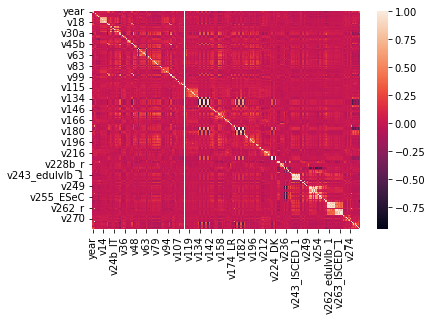

In [57]:
sns.heatmap(df_train.corr());

C:\Users\User\anaconda3\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\User\anaconda3\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


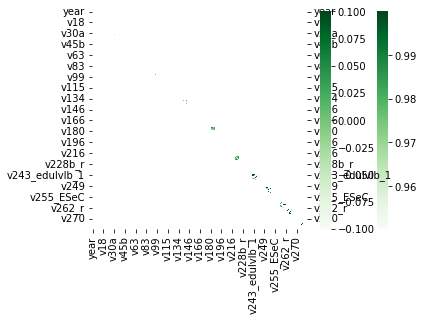

[('year', 'fw_start'), ('country', 'v275c_N2'), ('country', 'v275c_N1'), ('v20a', 'v20b'), ('v30b', 'v30c'), ('v45b', 'v45c'), ('v96a', 'v96b'), ('v135_11c', 'v136_11c'), ('v135_11c', 'v138_11c'), ('v135_11c', 'v141_11c'), ('v136_11c', 'v141_11c'), ('v138_11c', 'v141_11c'), ('v176_DK', 'v177_DK'), ('v176_DK', 'v178_DK'), ('v176_DK', 'v179_DK'), ('v176_DK', 'v180_DK'), ('v176_DK', 'v181_DK'), ('v176_DK', 'v182_DK'), ('v176_DK', 'v183_DK'), ('v177_DK', 'v178_DK'), ('v177_DK', 'v179_DK'), ('v177_DK', 'v180_DK'), ('v177_DK', 'v181_DK'), ('v177_DK', 'v182_DK'), ('v177_DK', 'v183_DK'), ('v178_DK', 'v179_DK'), ('v178_DK', 'v180_DK'), ('v178_DK', 'v181_DK'), ('v178_DK', 'v182_DK'), ('v178_DK', 'v183_DK'), ('v179_DK', 'v180_DK'), ('v179_DK', 'v181_DK'), ('v179_DK', 'v182_DK'), ('v179_DK', 'v183_DK'), ('v180_DK', 'v181_DK'), ('v180_DK', 'v182_DK'), ('v180_DK', 'v183_DK'), ('v181_DK', 'v182_DK'), ('v181_DK', 'v183_DK'), ('v182_DK', 'v183_DK'), ('v221_DK', 'v222_DK'), ('v221_DK', 'v223_DK'), ('v22

In [59]:
fig, ax = plt.subplots()
##kot1 = corr[corr>= 0.8]
##kot2 = corr[corr<= -0.8]
mask1 = np.logical_or(corr <= 0.95, corr == 1)
mask2 = np.logical_or(corr >= -0.95, corr == -1)

kot1 = corr.mask(mask1)
kot2 = corr.mask(mask2)
sns.heatmap(kot1, cmap="Greens")
ax2 = ax.twinx()
sns.heatmap(kot2, cmap="Greens")
plt.show()
pairs = []

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):  # i+1 to exclude self-correlation
        if (0.95 <= corr.iloc[i, j] <= 1) or (-1 <= corr.iloc[i, j] <= -0.95):
            pairs.append((corr.columns[i], corr.columns[j]))
print(pairs)

In [60]:
set_pairs = []

for e in pairs:
     set_pairs.append(set(e))
set_pairs

[{'fw_start', 'year'},
 {'country', 'v275c_N2'},
 {'country', 'v275c_N1'},
 {'v20a', 'v20b'},
 {'v30b', 'v30c'},
 {'v45b', 'v45c'},
 {'v96a', 'v96b'},
 {'v135_11c', 'v136_11c'},
 {'v135_11c', 'v138_11c'},
 {'v135_11c', 'v141_11c'},
 {'v136_11c', 'v141_11c'},
 {'v138_11c', 'v141_11c'},
 {'v176_DK', 'v177_DK'},
 {'v176_DK', 'v178_DK'},
 {'v176_DK', 'v179_DK'},
 {'v176_DK', 'v180_DK'},
 {'v176_DK', 'v181_DK'},
 {'v176_DK', 'v182_DK'},
 {'v176_DK', 'v183_DK'},
 {'v177_DK', 'v178_DK'},
 {'v177_DK', 'v179_DK'},
 {'v177_DK', 'v180_DK'},
 {'v177_DK', 'v181_DK'},
 {'v177_DK', 'v182_DK'},
 {'v177_DK', 'v183_DK'},
 {'v178_DK', 'v179_DK'},
 {'v178_DK', 'v180_DK'},
 {'v178_DK', 'v181_DK'},
 {'v178_DK', 'v182_DK'},
 {'v178_DK', 'v183_DK'},
 {'v179_DK', 'v180_DK'},
 {'v179_DK', 'v181_DK'},
 {'v179_DK', 'v182_DK'},
 {'v179_DK', 'v183_DK'},
 {'v180_DK', 'v181_DK'},
 {'v180_DK', 'v182_DK'},
 {'v180_DK', 'v183_DK'},
 {'v181_DK', 'v182_DK'},
 {'v181_DK', 'v183_DK'},
 {'v182_DK', 'v183_DK'},
 {'v221_DK', '

In [61]:
x = list(set().union(*set_pairs))

In [62]:
dic = {}
for e in x:
    dic[e] = df_train[e].corr(df_y['label'])

In [63]:
dic

{'v45c': 0.1296461037293339,
 'v221_DK': 0.030109978515633334,
 'age_r3': -0.11068710729614546,
 'v263_ISCED_3': 0.07755807849893542,
 'v178_DK': 0.09285646512972955,
 'v136_11c': 0.10872672571076003,
 'v180_DK': 0.09193870524470242,
 'v263_edulvlb_2': 0.07347822736796847,
 'v243_EISCED': 0.006023929747113932,
 'v263_8cat': 0.009471068751217457,
 'v275c_N2': 0.010156180748910696,
 'v243_ISCED_2b': 0.012588738454686558,
 'age': -0.11340228179823728,
 'v135_11c': 0.11814004422689767,
 'v222_DK': 0.02813511871440328,
 'v96a': 0.12388703510203042,
 'v252_edulvlb_2': 0.018219312633157573,
 'v243_ISCED97': 0.05834975137007219,
 'country': 0.02159482678941465,
 'v20b': -0.018572695493266175,
 'v183_DK': 0.09186789742338079,
 'v243_edulvlb_1': 0.06760889153108292,
 'v279c_r': -0.06423510998403359,
 'v275c_N1': 0.02149412663945133,
 'fw_start': -0.10998340790695299,
 'v263_ISCED_1': 0.0792914982660766,
 'v224_DK': 0.027579671286643008,
 'v252_r': -0.0052460660687199765,
 'v262_8cat': 0.01691941

In [64]:
remainder = []
for i in set_pairs:
    i = list(i)
    if abs(dic[i[0]]) > abs(dic[i[1]]):
        remainder.append(i[0])
    else:
        remainder.append(i[1])
remainder

['year',
 'country',
 'country',
 'v20b',
 'v30c',
 'v45c',
 'v96b',
 'v135_11c',
 'v138_11c',
 'v135_11c',
 'v141_11c',
 'v138_11c',
 'v177_DK',
 'v178_DK',
 'v179_DK',
 'v180_DK',
 'v181_DK',
 'v182_DK',
 'v183_DK',
 'v178_DK',
 'v179_DK',
 'v180_DK',
 'v177_DK',
 'v182_DK',
 'v183_DK',
 'v178_DK',
 'v178_DK',
 'v178_DK',
 'v178_DK',
 'v178_DK',
 'v179_DK',
 'v179_DK',
 'v179_DK',
 'v179_DK',
 'v180_DK',
 'v182_DK',
 'v180_DK',
 'v182_DK',
 'v183_DK',
 'v182_DK',
 'v221_DK',
 'v221_DK',
 'v221_DK',
 'v223_DK',
 'v222_DK',
 'v223_DK',
 'age',
 'age',
 'age_r3',
 'v243_edulvlb_2',
 'v243_edulvlb',
 'v243_ISCED_3',
 'v243_ISCED_1',
 'v243_edulvlb',
 'v243_8cat',
 'v243_edulvlb_2',
 'v243_ISCED_3',
 'v243_ISCED_1',
 'v243_edulvlb_2',
 'v243_edulvlb_2',
 'v243_ISCED_3',
 'v243_ISCED_1',
 'v243_edulvlb_1',
 'v243_8cat',
 'v243_ISCED_3',
 'v243_ISCED_3',
 'v243_ISCED_3',
 'v243_ISCED_2',
 'v243_ISCED_2',
 'v243_r',
 'v243_ISCED_2b',
 'v243_r',
 'v243_ISCED_1',
 'v243_ISCED_1',
 'v243_r',
 '

In [65]:
dropped = []
for i in set_pairs:
    i = list(i)
    if abs(dic[i[0]]) < abs(dic[i[1]]):
        dropped.append(i[0])
    else:
        dropped.append(i[1])
dropped

['fw_start',
 'v275c_N2',
 'v275c_N1',
 'v20a',
 'v30b',
 'v45b',
 'v96a',
 'v136_11c',
 'v135_11c',
 'v141_11c',
 'v136_11c',
 'v141_11c',
 'v176_DK',
 'v176_DK',
 'v176_DK',
 'v176_DK',
 'v176_DK',
 'v176_DK',
 'v176_DK',
 'v177_DK',
 'v177_DK',
 'v177_DK',
 'v181_DK',
 'v177_DK',
 'v177_DK',
 'v179_DK',
 'v180_DK',
 'v181_DK',
 'v182_DK',
 'v183_DK',
 'v180_DK',
 'v181_DK',
 'v182_DK',
 'v183_DK',
 'v181_DK',
 'v180_DK',
 'v183_DK',
 'v181_DK',
 'v181_DK',
 'v183_DK',
 'v222_DK',
 'v223_DK',
 'v224_DK',
 'v222_DK',
 'v224_DK',
 'v224_DK',
 'age_r',
 'age_r3',
 'age_r',
 'v243_edulvlb',
 'v243_edulvlb_1',
 'v243_edulvlb',
 'v243_edulvlb',
 'v243_ISCED97',
 'v243_edulvlb',
 'v243_edulvlb_1',
 'v243_edulvlb_2',
 'v243_edulvlb_2',
 'v243_ISCED97',
 'v243_8cat',
 'v243_edulvlb_1',
 'v243_edulvlb_1',
 'v243_ISCED97',
 'v243_edulvlb_1',
 'v243_ISCED_1',
 'v243_ISCED97',
 'v243_8cat',
 'v243_ISCED_2b',
 'v243_EISCED',
 'v243_ISCED_2',
 'v243_EISCED',
 'v243_ISCED_2b',
 'v243_ISCED97',
 'v24

In [66]:
intersection = set(remainder).intersection(set(dropped))
intersection

{'age_r3',
 'v135_11c',
 'v141_11c',
 'v177_DK',
 'v179_DK',
 'v180_DK',
 'v181_DK',
 'v182_DK',
 'v183_DK',
 'v222_DK',
 'v223_DK',
 'v243_8cat',
 'v243_ISCED97',
 'v243_ISCED_1',
 'v243_ISCED_2',
 'v243_ISCED_2b',
 'v243_edulvlb',
 'v243_edulvlb_1',
 'v243_edulvlb_2',
 'v243_r',
 'v252_ISCED97',
 'v252_ISCED_1',
 'v252_ISCED_2b',
 'v252_ISCED_3',
 'v252_edulvlb_2',
 'v262_EISCED',
 'v262_ISCED_2',
 'v262_ISCED_2b',
 'v262_ISCED_3',
 'v262_edulvlb',
 'v262_edulvlb_1',
 'v262_edulvlb_2',
 'v263_EISCED',
 'v263_ISCED_2b',
 'v263_ISCED_3',
 'v263_edulvlb',
 'v263_edulvlb_1',
 'v263_edulvlb_2',
 'v275c_N1',
 'v278c_r',
 'v279a'}

In [67]:
dic2 = {}

for e in intersection:
    dic2[e] = dic[e]
dic2

{'v263_ISCED_3': 0.07755807849893542,
 'age_r3': -0.11068710729614546,
 'v223_DK': 0.029611348975447357,
 'v180_DK': 0.09193870524470242,
 'v177_DK': 0.09175304028040755,
 'v263_edulvlb_2': 0.07347822736796847,
 'v263_edulvlb_1': 0.05973307632314733,
 'v263_EISCED': 0.009518884042687614,
 'v243_ISCED_2b': 0.012588738454686558,
 'v181_DK': 0.09174984046679806,
 'v135_11c': 0.11814004422689767,
 'v262_edulvlb': 0.06678152790239465,
 'v222_DK': 0.02813511871440328,
 'v182_DK': 0.09212389597836497,
 'v263_edulvlb': 0.07443485421758993,
 'v243_8cat': 0.06772412182189456,
 'v179_DK': 0.09273055240274354,
 'v252_edulvlb_2': 0.018219312633157573,
 'v243_ISCED97': 0.05834975137007219,
 'v243_edulvlb': 0.06769062590854757,
 'v263_ISCED_2b': 0.017100445372098982,
 'v183_DK': 0.09186789742338079,
 'v262_EISCED': 0.016972474229784686,
 'v243_ISCED_2': 0.013260241491645447,
 'v141_11c': 0.11633896057218256,
 'v243_edulvlb_1': 0.06760889153108292,
 'v243_edulvlb_2': 0.06795633750431936,
 'v275c_N1': 

In [68]:
for e in dropped:
    print(e)
    if not e in df_train.columns :
        continue
    df_train.drop(e, inplace=True, axis=1)
    df_test.drop(e, inplace=True, axis=1)

fw_start
v275c_N2
v275c_N1
v20a
v30b
v45b
v96a
v136_11c
v135_11c
v141_11c
v136_11c
v141_11c
v176_DK
v176_DK
v176_DK
v176_DK
v176_DK
v176_DK
v176_DK
v177_DK
v177_DK
v177_DK
v181_DK
v177_DK
v177_DK
v179_DK
v180_DK
v181_DK
v182_DK
v183_DK
v180_DK
v181_DK
v182_DK
v183_DK
v181_DK
v180_DK
v183_DK
v181_DK
v181_DK
v183_DK
v222_DK
v223_DK
v224_DK
v222_DK
v224_DK
v224_DK
age_r
age_r3
age_r
v243_edulvlb
v243_edulvlb_1
v243_edulvlb
v243_edulvlb
v243_ISCED97
v243_edulvlb
v243_edulvlb_1
v243_edulvlb_2
v243_edulvlb_2
v243_ISCED97
v243_8cat
v243_edulvlb_1
v243_edulvlb_1
v243_ISCED97
v243_edulvlb_1
v243_ISCED_1
v243_ISCED97
v243_8cat
v243_ISCED_2b
v243_EISCED
v243_ISCED_2
v243_EISCED
v243_ISCED_2b
v243_ISCED97
v243_8cat
v243_EISCED
v243_ISCED97
v243_r
v252_edulvlb_2
v252_edulvlb_1
v252_ISCED_3
v252_edulvlb_1
v252_edulvlb_2
v252_ISCED_1
v252_ISCED97
v252_edulvlb_1
v252_edulvlb_1
v252_edulvlb_1
v252_edulvlb_1
v252_ISCED_1
v252_ISCED97
v252_ISCED_2b
v252_EISCED
v252_EISCED
v252_ISCED_1
v252_r
v252_ISCED97

In [69]:
df_train.describe()

,year,fw_end,country,v1,v2,v3,v4,v5,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,f20,v20,v20b,v21,v22,v23,v24,f24_IT,v24a_IT,v24b_IT,v25,v26,v27,v28,v29,v30,f30a,v30a,v30c,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,f45a,v45a,v45c,v46,v47,v48,v49,v50,v51,v52,v52_cs,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,f85,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,f96,v96,v96b,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,f108,v108,v109,f110,v110,v111,v111_4,v112,f112_SE,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131,v132,v133,v133_11c,v134,v134_11c,v135,v136,v137,v137_11c,v138,v138_11c,v139,v139_11c,v140,v140_11c,v141,v142,v143,v144,v145,v146,v147,v148,v149,v150,v151,v152,v153,v154,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174_LR,v174_cs,v175_LR,v175_cs,v176,v177,v178,v178_DK,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v214,v215,v216,v217,v218,v219,v220,v221,v221_DK,v222,v223,v224,v225,v226,age,age_r2,v227,v228b_r,v229,v230,v231b_r,v232,v233b_r,v234,v235,v236,v237,v238,v239_r,v239a,v239b,v240,v241,v242,v242_r,v243_ISCED_3,v243_cs,v244,v245,v246_ISCO_2,v246_SIOPS,v246_ISEI,v246_ESeC,v246_egp,v247,v248,v248a,v249,v250,v251b_r,v252_edulvlb,v252_ISCED_2,v252_8cat,v252_cs,v253,v254,v255_ISCO_2,v255_ISEI,v255_egp,v256,v257,v258,v259,v260,v261,v261_ppp,v261_r,v262_ISCED_1,v262_r,v262_cs,v263_ISCED_2,v263_ISCED_1,v263_r,v263_cs,v264,v265,v266,v267,v268,v269,v270,v271,v272,v273,v274,v276_r,v277,v278b,v279b,v279c_r,v279d_r,v280,v281a_r,v282
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.0000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.0,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.00000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48

# Simple Model Run 2

In [70]:
label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)
# When creating DMatrix, enable categorical support
dtrain = xgb.DMatrix(df_train, label=df_y, enable_categorical=True)
dtest = xgb.DMatrix(df_test, enable_categorical=True)

# Set XGBoost parameters 
params = {
    'max_depth': 6,
    'eta': 0.01,
    'objective': 'multi:softprob',
    'num_class': 5,  # We have 5 classes: 0, 1, 2, 3, 4
    'eval_metric': 'mlogloss',
}
num_boost_round = 700  # Number of boosting rounds

bst = xgb.train(params, dtrain, num_boost_round)
y_test_probs = bst.predict(dtest)

class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class_{class_label}" for class_label in class_order}

submission_df = pd.DataFrame(y_test_probs, columns=class_mapping.values())
submission_df.columns = ['no answer', 'very important', 'quite important', 'not important', 'not at all important']
submission_df.insert(0, 'id', df_test.index)

# Save the submission file
# submission_file = 'submission.csv'
submission_file = 'submission.xlsx'
## submission_df.to_csv(submission_file,lineterminator=None, index=False)
with pd.ExcelWriter(submission_file) as writer:
    submission_df.to_excel(writer, sheet_name="Sheet1") 

In [71]:
from xgboost import cv

# params and num_boost_round provided above
xgb_cv = cv(dtrain=dtrain, params=params, nfold=5,
            num_boost_round=num_boost_round, early_stopping_rounds=10,
            metrics="mlogloss", as_pandas=True, seed=123)

xgb_cv

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,1.600915,0.000045,1.601241,0.000048
1,1.592534,0.000071,1.593175,0.000088
2,1.584288,0.000097,1.585240,0.000139
3,1.576183,0.000121,1.577443,0.000184
4,1.568213,0.000146,1.569781,0.000230
5,1.560380,0.000177,1.562263,0.000254
6,1.552662,0.000198,1.554849,0.000307
7,1.545073,0.000218,1.547569,0.000339
8,1.537594,0.000238,1.540394,0.000383
9,1.530245,0.000264,1.533350,0.000413


In [73]:
from sklearn.metrics import log_loss

In [74]:
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round, 
                evals=[(dtrain, 'train')], evals_result=evals_result, 
                verbose_eval=False)
print(f"Training Multiclass Logarithmic Loss: {evals_result['train']['mlogloss'][-1]}")

y_test_probs = bst.predict(dtest)

class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class_{class_label}" for class_label in class_order}

y_train_probs = bst.predict(dtrain)
val_log_loss = log_loss(df_y, y_train_probs, labels=class_order)
print(f"Validation Multiclass Logarithmic Loss: {val_log_loss}")

Training Multiclass Logarithmic Loss: 0.7233574233316661
Validation Multiclass Logarithmic Loss: 0.7233574151666059


# Optimizing parameter and Model Run

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
X_train, X_test, y_train, y_test = train_test_split(df_train, df_y, test_size = 0.2, random_state = 0)




In [117]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 700,
        'eta' : 0.01,
        'seed': 123
    }


In [120]:
def objective(space):
    clf=xgb.XGBClassifier(eta = space['eta'],
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="mlogloss",
            early_stopping_rounds=20,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [121]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.4203125                                              
SCORE:                                                                   
0.4246875                                                                
SCORE:                                                                   
0.4138541666666667                                                       
SCORE:                                                                   
0.42322916666666666                                                      
SCORE:                                                                   
0.4169791666666667                                                       
SCORE:                                                                   
0.416875                                                                 
SCORE:                                                                   
0.4161458333333333                                                       


In [122]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9439938567173259, 'gamma': 3.5834865470833823, 'max_depth': 17.0, 'min_child_weight': 0.0, 'reg_alpha': 40.0, 'reg_lambda': 0.9633541550944799}


In [123]:
def objective_final(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="mlogloss",
            early_stopping_rounds=20,verbose=True)
    
    y_train_probs = clf.predict_proba(df_train)
    pred = clf.predict_proba(df_test)
    return [y_train_probs, pred]

In [124]:
best_hyperparams['n_estimators']= 700
best_hyperparams['seed'] = 123
best_hyperparams['eta'] = 0.01
pred_list=objective_final(best_hyperparams)

[0]	validation_0-mlogloss:1.55099	validation_1-mlogloss:1.55039
[1]	validation_0-mlogloss:1.51375	validation_1-mlogloss:1.51332
[2]	validation_0-mlogloss:1.48787	validation_1-mlogloss:1.48685
[3]	validation_0-mlogloss:1.46849	validation_1-mlogloss:1.46743
[4]	validation_0-mlogloss:1.45191	validation_1-mlogloss:1.45084
[5]	validation_0-mlogloss:1.43771	validation_1-mlogloss:1.43653
[6]	validation_0-mlogloss:1.42492	validation_1-mlogloss:1.42418
[7]	validation_0-mlogloss:1.41708	validation_1-mlogloss:1.41616
[8]	validation_0-mlogloss:1.40360	validation_1-mlogloss:1.40235
[9]	validation_0-mlogloss:1.39298	validation_1-mlogloss:1.39221
[10]	validation_0-mlogloss:1.38478	validation_1-mlogloss:1.38386
[11]	validation_0-mlogloss:1.36488	validation_1-mlogloss:1.36418
[12]	validation_0-mlogloss:1.35950	validation_1-mlogloss:1.35867
[13]	validation_0-mlogloss:1.35524	validation_1-mlogloss:1.35460
[14]	validation_0-mlogloss:1.35267	validation_1-mlogloss:1.35206
[15]	validation_0-mlogloss:1.33291	

In [125]:
##print(f"Training Multiclass Logarithmic Loss: {evals_result['train']['mlogloss'][-1]}")

y_test_probs = pred_list[1]

class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class_{class_label}" for class_label in class_order}

y_train_probs = pred_list[0]
val_log_loss = log_loss(df_y, y_train_probs, labels=class_order)
print(f"Validation Multiclass Logarithmic Loss: {val_log_loss}")

Validation Multiclass Logarithmic Loss: 0.9447869923200148
